# <center>Graphene quantum Hall effect (with 8 leads)</center>
<hr>

In [1]:
import kwant
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib

### Figures Management

In [2]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 14,
    'toolbar': 'None',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'legend.fancybox': False,
    'legend.shadow': False
})

fig_path = "./figures/"

### Fundamental constants

In [3]:
h = 6.626069e-34  # Planck constant (Js)
h_bar =h/(2*np.pi) # With h_bar oom larger and Bmax=30, it works perfectly

# Scaling factor of 10 required --> h_bar normal, Bmax=3

e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)

### Scaling

In [4]:
asquare = 1e-9 # [m] a is the lattice parameter
tsquare = 1 # [eV] t is the hopping parameter

# scaling

scaling = 4 # scaling factor
a = asquare * scaling
t = tsquare / scaling

### Geometrical parameters

In [5]:
W=200e-9 ; L = 1000e-9 # let's try W = 200, 400, 600, 800

# For width smaller than 50 nm, the script does not work since the magnetic length is 30 nm so wf start to overlap (?)
# Also for width slightly larger than that, the steps in the Hall resistance are lost. For w=200 nm they are recovered.

width_lead=15e-9                                         
posL = 450e-9 # pos of the leads along x # 350e-9 before
L_lead_central=100e-9
lead_ext = posL + width_lead / 2
lead_int = posL - width_lead / 2

flag=0

#### Geometry of the device

In [6]:
def geom(pos):
    x, y = pos
    return abs(x) < L / 2 and abs(y) < W / 2

#### Geometry of the leads

In [7]:
def lead_shape(pos):
    x, y = pos
    return -W/2 < y < W/2


def lead_shape_left(pos):
    x, y = pos
    return -lead_ext < x < -lead_int


def lead_shape_right(pos):
    x, y = pos    
    return lead_int < x < lead_ext


def lead_center(pos):
    x,y= pos
    return (abs(x)<L_lead_central/2) 

#### Potentials & Disorder

The minus sign in the expression of the potentials comes from the fact that those potentials are associated to the potential energy of an electron ($qV = -eV$). Introducing a disorder of 0.01 leads to peaks in longitudinal resistance but we retain anyway plateaus in Hall resistance.


In [8]:
def step_potential(x, y):

    region_1 = 150e-9
    w_pot = 0
    
    in_region_1 = abs(x) < region_1 and abs(y) < W / 2 - w_pot
    
    return (-1) * in_region_1 * v_tip


def smooth_potential(x, y):
    
    region_1 = 150e-9
    w_pot = 0
    
    in_region_1 = abs(x) < region_1 and abs(y) < W / 2 - w_pot
    
    return (-1) * in_region_1 * np.cos(abs(x) * np.pi / (2 * region_1)) * (v_tip - 0.01)


def lorentzian_potential(x, y):
    
    a = v_tip**-1
    
    return (-1) * a / ((x * 1.1e8)**2 + (y * 1.1e8)**2 + a**2)


def stair_potential(x, y):
    
    region_1 = 50e-9
    region_2 = 200e-9
    w_pot = 0 

    in_region_2 = abs(x) < region_2 and abs(y) < W / 2 - w_pot
    in_region_1 = abs(x) < region_1 and abs(y) < W / 2 - w_pot
    
    return (-1) * (in_region_1 + in_region_2) * v_tip / 2


def disorder(pos):
    x, y = pos
    
#     pot = 0.01 * random.uniform(-t / 2, t / 2)
    pot = 0
    
    return pot

#### Defining onsite and hopping parameters

In [9]:
def onsite(site):
    """
    Definition of the potential. To reach the bottom of the conduction band, the potential is set at 4*t.
    A zone of potential v_tip (above the bottom of the conduction band) can be defined in a given zone 
    (square or circle here). 
    """
    x, y = site.pos
    
        
    return potential_function(x, y) + disorder(site) 

#### Hopping parameter

In [10]:
def hopping(site_i, site_j):  
    
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    
    # The definition of hop to include the magnetic field Bfield in the definition of the hopping parameter
    
    hop = t * np.exp(1j * e * Bfield * (yi + yj) * (xj - xi) / (2 * h_bar))
    
    return hop

## Building the system

In [11]:
def sys_builder():
    
    graphene = kwant.lattice.general([(np.sqrt(3) * a, 0), (0, 3 * a)], 
                                     [(a * np.sqrt(3) / 2, 0), (0, a / 2), (0, 3 * a / 2), (a * np.sqrt(3) / 2, 2 * a)], 
                                     norbs = 1)
    
    A, B, C, D = graphene.sublattices
      
    sys = kwant.Builder()
    sys[graphene.shape(geom, (0,0))] = onsite
    
    hoppings = (((0, 0), B, A), ((0, 0), C, B), ((0, 0), D, C), ((-1, 0), A, B), ((-1, 0), D, C), ((0, 1), A, D)) 
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping

# Schematic of the Hall bar
#   ,----------o----Vxx----.--------------.
#   |  Lead 3  |           |  Lead 5    __|__
#  Vxy     __|   |_______|   |__        '''''    (ground)
#   |               I
#   | Lead 1      ----->      Lead 2
#   |      __     _______     __
#   |        |   |       |   |
#   |  Lead 4  |               Lead 6
#   `----------'
    
    """ Lead 1 """
    sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[graphene.shape(lead_shape, (0, 0))] = 0 # is it really zero here? I think yes
    lead0[graphene.neighbors()] = hopping

    """ Lead 2 """
    sym1 = kwant.TranslationalSymmetry(graphene.vec((1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[graphene.shape(lead_shape, (0, 0))] = 0    
    lead1[graphene.neighbors()] = hopping

    """ Lead 3 """
    sym2 = kwant.TranslationalSymmetry(graphene.vec((0, 1)))
    lead2 = kwant.Builder(sym2)
    lead2[graphene.shape(lead_shape_left, (-posL, 0))] = 0
    lead2[graphene.neighbors()] = hopping

    """ Lead 4 """
    sym3 = kwant.TranslationalSymmetry(graphene.vec((0, -1)))
    lead3 = kwant.Builder(sym3)
    lead3[graphene.shape(lead_shape_left, (-posL, 0))] = 0
    lead3[graphene.neighbors()] = hopping

    """Lead 5"""
    lead4=kwant.Builder(sym2)
    lead4[graphene.shape(lead_center, (0,0))] = 0
    lead4[graphene.neighbors()] = hopping
    
    """Lead 6"""
    lead5=kwant.Builder(sym3)
    lead5[graphene.shape(lead_center, (0,0))] = 0
    lead5[graphene.neighbors()] = hopping
    
    """ Lead 7 """                             #sym already created with the correct symmetry, you just need to put the correct position
    lead6 = kwant.Builder(sym2)
    lead6[graphene.shape(lead_shape_right, (posL, 0))] = 0
    lead6[graphene.neighbors()] = hopping
    
    """Lead 8"""
    lead7 = kwant.Builder(sym3)
    lead7[graphene.shape(lead_shape_right, (posL,0))] = 0
    lead7[graphene.neighbors()] = hopping
    
    """ The leads are attached """
    sys.attach_lead(lead0)
    sys.attach_lead(lead1)
    sys.attach_lead(lead2)
    sys.attach_lead(lead3)
    sys.attach_lead(lead4)
    sys.attach_lead(lead5)
    sys.attach_lead(lead6)
    sys.attach_lead(lead7)
 
    sys = sys.finalized()
    
    return sys   

In [12]:
sys = sys_builder()

#### Plotting the system

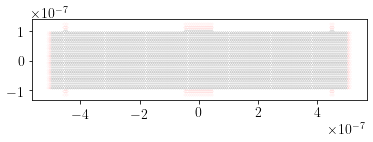

In [13]:
kwant.plot(sys, site_size = 1e-9, file=fig_path + "lattice.pdf")

## Electronic properties

In [14]:
Ef = 0.148
Bfield = 1.82
v_tip = -0.02
potential_function = step_potential

params = dict(Bfield = Bfield, v_tip = v_tip) # params take the magnetic field as a parameter for the function hopping

In [15]:
# The wavelength must be (much more) larger than the lattice parameter 
# We can also check the width of the device w.r.t. the magnetic length, which is the extension of the wf 

lambda_F = 3 * np.pi * t* a /abs(Ef) # computation of the wavelength
mag_length=np.sqrt(h_bar/(e*Bfield))

if lambda_F/a < 2:
    print('Warning : lambda_F must be larger than the lattice parameter a')
    
if mag_length > W/2:
    print('Warning : wavefunctions extend across the whole bar')

#### Visualization of the Landau Levels

LL-4 = -0.22308232368408085
LL-3 = -0.19319495944567694
LL-2 = -0.15774302383986594
LL-1 = -0.11154116184204042
LL0 = -0.0
LL1 = 0.11154116184204042
LL2 = 0.15774302383986594
LL3 = 0.19319495944567694
LL4 = 0.22308232368408085
Fermi Energy =0.148


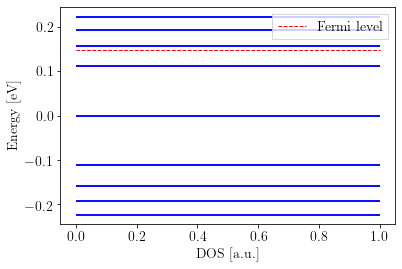

In [16]:
num_ll = 5
ll_indexes = np.arange(0, num_ll)
lls = -3 * t * a * np.sqrt(e  * ll_indexes * Bfield / (2 * h_bar))
lls = np.append(lls[::-1], -lls[1:])

plt.figure()

for n, ll in enumerate(lls):
     
    # Landau levels as a function of the magnetic field Bfield and the Landau level label n
    plt.hlines(ll, 0, 1, color="b")
    plt.hlines(ll, 0, 1, color="b")
    print(f'LL{n - (num_ll - 1)} = {ll}')
    
print (f'Fermi Energy ={Ef}')
    
plt.hlines(Ef, 0, 1, colors='r', linestyles="dashed", label='Fermi level', linewidth=1) # to plot the Fermi energy (in red)
plt.xlabel('DOS [a.u.]')
plt.ylabel('Energy [eV]')
plt.legend()
plt.show()

### Visualization of the LL + step potential

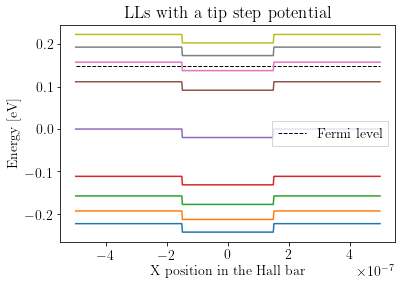

In [17]:
N=500
x_positions = np.linspace(-L / 2, L / 2, N)
y_positions = np.linspace(-W / 2, W / 2)
ll_pot_matrix = np.zeros((2 * num_ll - 1, N))

for x_idx, x_pos in enumerate(x_positions):
    ll_pot_matrix[:, x_idx] = lls[:] + potential_function(x_pos, 0)

plt.figure()
for ll_row in ll_pot_matrix:
    
    plt.plot(x_positions, ll_row)

plt.hlines(Ef, -L/2, L/2, colors='k', linestyles="dashed", label='Fermi level', linewidth=1)
plt.xlabel('X position in the Hall bar')
plt.ylabel('Energy [eV]')
plt.title(f'LLs with a tip {potential_function.__name__.replace("_", " ")}')
plt.legend()

if(potential_function is lorentzian_potential):
    
    plt.figure()
    xx, yy = np.meshgrid(x_positions, y_positions)
    zz = lorentzian_potential(xx, yy)
    plt.contourf(xx, yy, zz, cmap="jet")
    plt.axis('equal')

plt.show()

### Current and wf density

#### Wave function

In [18]:
wfs = kwant.wave_function(sys, energy=Ef, params = params) # the wf is obtained by giving the parameters in arguments
scattering_wf = wfs(0) # all scattering wave functions from lead 0

#### Current density


In [24]:
# To obtain edge states, a strong field is required, in order to be in the high magnetic field regime. 2 T gives edge states, 
# 0.1 T gives normal conduction

J0 = kwant.operator.Current(sys)
wf_left = wfs(0)
wf_right = wfs(1)

current = sum(J0(p, params = params) for p in wf_left) # to sum over all the lead's mode
current_right=sum(J0(p, params = params) for p in wf_right)

if (1): # put 1 if you want to save the currents in pdf.
    kwant.plotter.current(sys, current, cmap="jet", max_linewidth=0, min_linewidth=0, 
                          file=fig_path + f"{potential_function.__name__}_current_left_8.pdf")
    kwant.plotter.current(sys, current_right, cmap="jet", max_linewidth=0, min_linewidth=0, 
                          file=fig_path + f"{potential_function.__name__}_current_right_8.pdf")
else:
    kwant.plotter.current(sys, current, cmap="jet", max_linewidth=0, min_linewidth=0)
    kwant.plotter.current(sys, current_right, cmap="jet", max_linewidth=0, min_linewidth=0)
plt.show()

/tmp/ipykernel_15159/157166435.py:12: RuntimeWarning: invalid value encountered in true_divide
  kwant.plotter.current(sys, current, cmap="jet", max_linewidth=0, min_linewidth=0,
/tmp/ipykernel_15159/157166435.py:14: RuntimeWarning: invalid value encountered in true_divide
  kwant.plotter.current(sys, current_right, cmap="jet", max_linewidth=0, min_linewidth=0,


To have clear current plots you have to make sure the potential zone does not overlap with the leads.

### Plotting Hall conductance as function of the back gate voltage applied (Fermi level)

In [20]:
Ef_min = lls[0 + (num_ll - 1)] + 5e-2  # at ll0
Ef_max = lls[3 + (num_ll - 1)] + 5e-2  # at ll+3 
num_it = 200 # discretization of the fermi level 
num_leads = 8

fermi_energies = np.linspace(Ef_min, Ef_max, num_it)
R = np.zeros((num_it, num_leads - 1)) # r_xx = R[:, 3] and r_xy = R[:, 4]

params = dict(Bfield = Bfield, v_tip = v_tip)

for idx, en in enumerate(fermi_energies):
        
    try:    
        s = kwant.smatrix(sys, energy=en, params=params)
        cond = np.array([[s.transmission(i, j) for j in range(num_leads)] for i in range(num_leads)])     
        cond -= np.diag(cond.sum(axis=0))  
        cm = s.conductance_matrix()[:-1, :-1] # we don't even use the cond matrix so what is the point?
#         cm = cond[:-1, :-1]
        
        R[idx] = np.linalg.solve(cm, [1, -1, 0, 0, 0, 0, 0])
    
    except Exception as e:
        
        print(f'problem encountered at iteration {idx} with fermi energy {en} with the following error: \n {e}')

### Hall resistivity vs Fermi Energy

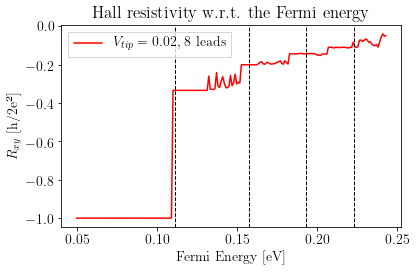

In [21]:
plt.figure()
plt.title("Hall resistivity w.r.t. the Fermi energy")
plt.plot(fermi_energies, R[:, 6], color="red", label="$V_{tip}=" + f"{v_tip}$, 8 leads")

for _, ll in enumerate(lls):
    if(Ef_min < ll < Ef_max):
        plt.axvline(x=ll, color='k', linestyle='--', linewidth=1)
        
plt.xlabel('Fermi Energy [eV]')
plt.ylabel('$R_{xy}$ [h/2e²]')
plt.legend()

if(1):
    plt.tight_layout()
    plt.savefig('hr8_p02_nd.pdf')
else: 
    plt.show()

### Longitudinal resistivity vs Fermi energy (with non-zero tip potential)

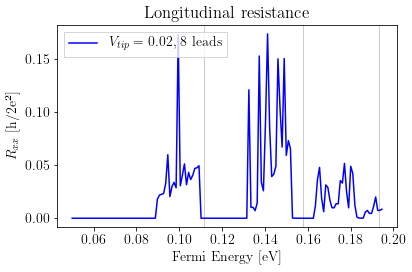

In [40]:
overhead_amount = 150
# 140
plt.figure()
plt.title("Longitudinal resistance")
plt.plot(fermi_energies[:overhead_amount], R[:overhead_amount, 3], color='blue', label="$V_{tip}=" + f"{v_tip}$, 8 leads")

# plt.axhline(y=1/3, linestyle='--')
# plt.axhline(y=1/2.5, color='k')

for _, ll in enumerate(lls):
    if(Ef_min < ll < 0.2):
        plt.axvline(x=ll, color='k', alpha=0.2, linewidth=1)
        
plt.xlabel('Fermi Energy [eV]')
plt.ylabel('$R_{xx}$ [h/2e²]')
plt.legend(loc=2)

if(1):
    plt.tight_layout()
    plt.savefig(fig_path + 'lr8_p02_nd.pdf')
else: 
    plt.show()